In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
from timm import create_model
import torch.optim as optim
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

# ==== Cài đặt chung ====
data_dir = r"C:\Users\Admin\Documents\Python Project\Res conn 2025\final_data\not_seg"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
# ==== Tiền xử lý ====
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset với transform mặc định (chưa có augmentation) để chia dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=val_test_transform)

# ==== Chia dataset thành train, val, test ====
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.11

total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Vì train_dataset, val_dataset, test_dataset là subset nên phải thay đổi transform thủ công:
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# ==== DataLoader ====
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ==== Mô hình ViT ====
model = create_model('vit_base_patch16_224', pretrained=True, num_classes=len(full_dataset.classes))

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

# ==== EarlyStopping ====
class EarlyStopping:
    def __init__(self, patience=4, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

early_stopping = EarlyStopping(patience=5, min_delta=0.001)

# ==== Training loop ====
epochs = 300
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if early_stopping(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break


c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 1, Train Loss: 0.3003, Val Loss: 0.2690
Epoch 2, Train Loss: 0.1706, Val Loss: 0.1985
Epoch 3, Train Loss: 0.1271, Val Loss: 0.3201
Epoch 4, Train Loss: 0.1301, Val Loss: 0.2304
Epoch 5, Train Loss: 0.0862, Val Loss: 0.2709
Epoch 6, Train Loss: 0.0872, Val Loss: 0.2550
Epoch 7, Train Loss: 0.0713, Val Loss: 0.2649
Early stopping at epoch 7


In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy on test set: {100 * correct / total:.2f}%")


Accuracy on test set: 92.09%


In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch
import torch.nn as nn
from timm import create_model
import torch.optim as optim
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter

# ==== Cài đặt chung ====
data_dir = r"C:\Users\Admin\Documents\Python Project\Res conn 2025\final_data\not_seg"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==== Tiền xử lý ====
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ==== Load dataset không gán transform ban đầu ====
full_dataset = datasets.ImageFolder(root=data_dir)
targets = [sample[1] for sample in full_dataset.samples]

# ==== Stratified Split: train (80%) / val (9%) / test (11%) ====
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.21, random_state=42)
train_idx, temp_idx = next(sss.split(np.zeros(len(targets)), targets))

temp_targets = [targets[i] for i in temp_idx]
sss_temp = StratifiedShuffleSplit(n_splits=1, test_size=0.524, random_state=42)  # ~11% test
val_idx, test_idx = next(sss_temp.split(np.zeros(len(temp_targets)), temp_targets))
val_idx = [temp_idx[i] for i in val_idx]
test_idx = [temp_idx[i] for i in test_idx]

# ==== Tạo Subset dataset và gán transform ====
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# ==== Kiểm tra phân phối lớp (tùy chọn) ====
print("Train class distribution:", Counter([targets[i] for i in train_idx]))
print("Val class distribution:", Counter([targets[i] for i in val_idx]))
print("Test class distribution:", Counter([targets[i] for i in test_idx]))

# ==== DataLoader ====
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ==== Mô hình ViT ====
model = create_model('vit_base_patch16_224', pretrained=True, num_classes=len(full_dataset.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

# ==== EarlyStopping ====
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

early_stopping = EarlyStopping()

# ==== Training loop ====
epochs = 300
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if early_stopping(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break


c:\Users\Admin\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Train class distribution: Counter({16: 1815, 9: 1434, 3: 1319, 10: 1092, 12: 1036, 11: 850, 4: 831, 5: 675, 6: 618, 0: 562, 1: 490, 14: 395, 13: 395, 15: 395, 8: 316, 7: 310, 2: 284, 17: 284})
Val class distribution: Counter({16: 229, 9: 181, 3: 167, 10: 139, 12: 131, 11: 108, 4: 105, 5: 85, 6: 78, 0: 71, 1: 62, 13: 50, 15: 50, 14: 50, 8: 40, 7: 39, 17: 36, 2: 36})
Test class distribution: Counter({16: 253, 9: 200, 3: 184, 10: 152, 12: 144, 11: 118, 4: 116, 5: 94, 6: 86, 0: 78, 1: 69, 13: 55, 14: 55, 15: 55, 8: 44, 7: 43, 2: 40, 17: 40})
Epoch 1, Train Loss: 0.3052, Val Loss: 0.2247
Epoch 2, Train Loss: 0.1695, Val Loss: 0.2069
Epoch 3, Train Loss: 0.1465, Val Loss: 0.2320
Epoch 4, Train Loss: 0.1132, Val Loss: 0.2853
Epoch 5, Train Loss: 0.1213, Val Loss: 0.2857
Epoch 6, Train Loss: 0.0909, Val Loss: 0.2591
Epoch 7, Train Loss: 0.0729, Val Loss: 0.2622
Early stopping at epoch 7


In [2]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ==== Tính toán chỉ số đánh giá ====
print(f"Accuracy on test set: {100 * np.mean(np.array(all_preds) == np.array(all_labels)):.2f}%")

report = classification_report(all_labels, all_preds, target_names=full_dataset.classes, digits=4)
print("\nClassification Report:\n", report)


Accuracy on test set: 91.57%

Classification Report:
                                             precision    recall  f1-score   support

                        Apple___Apple_scab     1.0000    1.0000    1.0000        78
                         Apple___Black_rot     0.9718    1.0000    0.9857        69
                  Apple___Cedar_apple_rust     0.9756    1.0000    0.9877        40
                           Apple___healthy     0.9945    0.9891    0.9918       184
  Cherry_(including_sour)___Powdery_mildew     1.0000    1.0000    1.0000       116
         Cherry_(including_sour)___healthy     1.0000    0.9787    0.9892        94
                          Grape Brown_Spot     0.6452    0.6977    0.6704        86
                        Grape Downy_Mildew     0.2609    0.4186    0.3214        43
                       Grape Mites_Disease     0.4571    0.3636    0.4051        44
                         Grape___Black_rot     0.8547    0.7650    0.8074       200
              Grape__

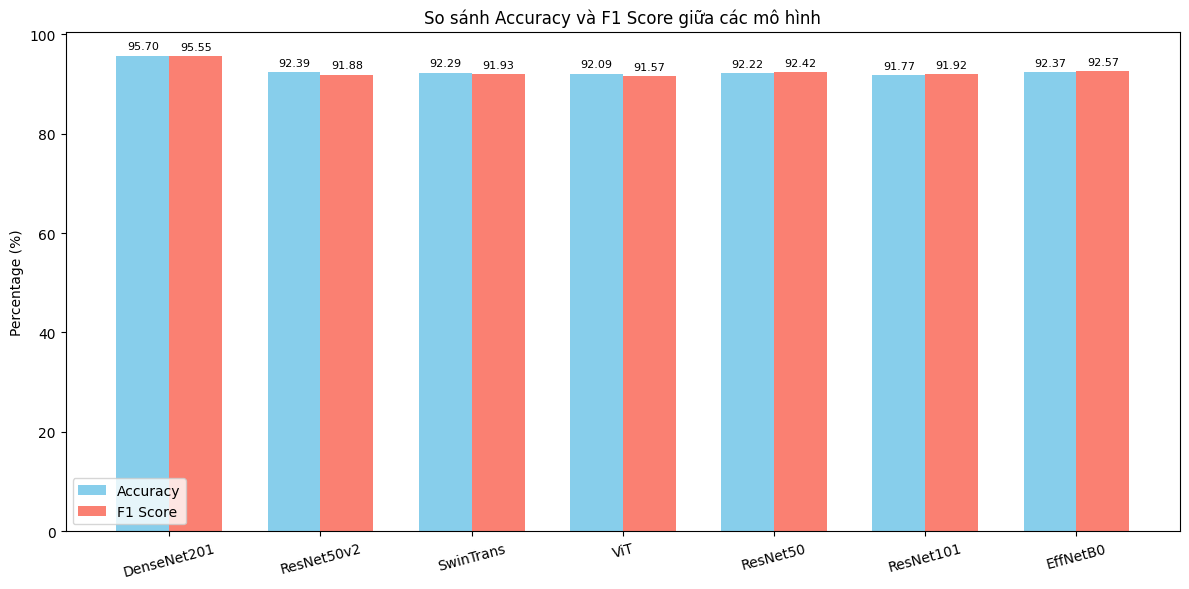

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Tên các mô hình
models = [
    "DenseNet201", "ResNet50v2", "SwinTrans", 
    "ViT", "ResNet50", "ResNet101", "EffNetB0"
]

# Accuracy và F1 score tương ứng
accuracy = [95.70, 92.39, 92.29, 92.09, 92.22, 91.77, 92.37]
f1_score = [0.9555, 0.9188, 0.9193, 0.9157, 0.9242, 0.9192, 0.9257]

# Thiết lập vị trí cột
x = np.arange(len(models))
width = 0.35

# Vẽ biểu đồ
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, accuracy, width, label='Accuracy', color='skyblue')
bars2 = ax.bar(x + width/2, [f*100 for f in f1_score], width, label='F1 Score', color='salmon')

# Thêm nhãn và tiêu đề
ax.set_ylabel('Percentage (%)')
ax.set_title('So sánh Accuracy và F1 Score giữa các mô hình')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.legend()

# Gắn nhãn trên đầu cột
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()
